**Task 3**

# Extension to Regression: Detecting Extrapolation Regions with a Bayesian Neural Network

This notebook explores the application of Bayesian Neural Networks (BNNs) to a nonlinear regression problem. The goal is to use uncertainty estimates from the BNN to identify data points that lie in the extrapolation region, where the model lacks sufficient training data for accurate predictions.

---

## 1. Problem Setup

The regression problem involves fitting a nonlinear function to a set of training data. The BNN is trained to model both the function and the uncertainty of its predictions. Extrapolation regions, where the model has less confidence in its predictions, are identified by analyzing uncertainty estimates.

- **Training Data**: The training data is selected to represent a subset of the overall domain, ensuring the existence of regions where the model has no exposure to training samples.
- **Extrapolation Region**: The extrapolation region is defined as the domain outside the training data range, where uncertainty is expected to increase significantly.

---

## 2. Bayesian Neural Network Training

### Model Architecture:
- The BNN is implemented using PyMC, a probabilistic programming library.
- The model includes both weights and biases as probabilistic parameters, enabling it to capture uncertainty in predictions.

### Uncertainty Estimation:
- The BNN generates a posterior predictive distribution for each input point.
- Uncertainty is quantified using metrics such as the standard deviation of predictions from the posterior distribution.

---

## 3. Detecting Extrapolation Regions

### Step 1: Threshold Calculation
- **Percentile-Based Threshold**: A threshold for uncertainty is computed based on the 77th percentile of the uncertainty values for extrapolated data points.
- **Purpose**: Points with uncertainty exceeding this threshold are classified as belonging to the extrapolation region.

### Step 2: Identifying Extrapolated Points
- The indices of extrapolated points are determined by comparing the uncertainty values to the calculated threshold.

---

## 4. Results

### Key Outputs:
- **Threshold Value**: A threshold value of `6.85` was calculated based on the 77th percentile of uncertainty values.
- **Number of Extrapolated Points**: A total of `17` points were detected as being in the extrapolation region.

### Interpretation:
- The high uncertainty in the extrapolation region aligns with the model's lack of exposure to training data in these areas.
- By quantifying uncertainty, the BNN effectively identifies points that lie outside the training data range.

---

This task demonstrates the power of Bayesian Neural Networks in leveraging uncertainty estimates for tasks beyond traditional regression, such as detecting extrapolation regions. The methodology can be extended to other domains requiring robust uncertainty quantification.



In [ ]:
!pip install ucimlrepo


In [ ]:
# Standard library imports
import numpy as np

# Third-party library imports
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, OneHotEncoder
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler


# PyMC and PyTensor imports
import pymc as pm
import pymc.math as pmath
import pytensor

# ArviZ imports
import arviz as az

In [ ]:
import seaborn as sns

# Load the Auto MPG dataset
mpg = sns.load_dataset('mpg')

mpg = mpg.dropna()

X = mpg[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin']]
y = mpg['mpg']

print("Features (X):")
print(X.head())

print("\nTarget (y):")
print(y.head())


Features (X):
   cylinders  displacement  horsepower  weight  acceleration  model_year  \
0          8         307.0       130.0    3504          12.0          70   
1          8         350.0       165.0    3693          11.5          70   
2          8         318.0       150.0    3436          11.0          70   
3          8         304.0       150.0    3433          12.0          70   
4          8         302.0       140.0    3449          10.5          70   

  origin  
0    usa  
1    usa  
2    usa  
3    usa  
4    usa  

Target (y):
0    18.0
1    15.0
2    18.0
3    16.0
4    17.0
Name: mpg, dtype: float64


In [ ]:
import pandas as pd

# 1. Drop the 'name' column (not useful)
mpg = mpg.drop(columns=['name'])

# 2. Fill missing values in 'horsepower' with the column mean
mpg['horsepower'] = mpg['horsepower'].fillna(mpg['horsepower'].mean())

# 3. Convert 'origin' to a numerical variable (one-hot encoding)
mpg = pd.get_dummies(mpg, columns=['origin'], drop_first=True)

# 4. Select features and target
X = mpg.drop(columns=['mpg'])  # Features
y = mpg['mpg']  # Target (mpg)

# Display the prepared dataset
print(X.head())
print(y.head())


   cylinders  displacement  horsepower  weight  acceleration  model_year  \
0          8         307.0       130.0    3504          12.0          70   
1          8         350.0       165.0    3693          11.5          70   
2          8         318.0       150.0    3436          11.0          70   
3          8         304.0       150.0    3433          12.0          70   
4          8         302.0       140.0    3449          10.5          70   

   origin_japan  origin_usa  
0         False        True  
1         False        True  
2         False        True  
3         False        True  
4         False        True  
0    18.0
1    15.0
2    18.0
3    16.0
4    17.0
Name: mpg, dtype: float64


In [ ]:
# Setting the interval for the training set
values = (mpg['cylinders'] >= 3) & (mpg['cylinders'] <= 6)


# Separate the data for 'cylinders = 7'
data_cyl_7 = mpg[mpg['cylinders'] == 7]

mpg.to_csv("preprocessed_mpg.csv", index=False)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of training data:", X_train.shape)
print("Shape of test data:", X_test.shape)

# Load the Auto MPG dataset
import seaborn as sns

mpg = sns.load_dataset("mpg").dropna()

# Select features and target
X = mpg[["cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year", "origin"]]
y = mpg["mpg"]

# Apply one-hot encoding to categorical features
X = pd.get_dummies(X, columns=["origin"], drop_first=True)

# Standardize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
RANDOM_SEED = 9927
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=RANDOM_SEED)

# Convert to numpy format
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.to_numpy().astype(np.float64)
y_test = y_test.to_numpy().astype(np.float64)


Shape of training data: (313, 8)
Shape of test data: (79, 8)


In [ ]:
def create_bayesian_network(input_data, output_data):

    # Define a Bayesian neural network for regression

    coords = {
        "input_features": np.arange(input_data.shape[1]),
        "samples": np.arange(input_data.shape[0]),
    }

    with pm.Model(coords=coords) as bayesian_nn:
        # Define input and output data
        model_input = pm.Data("model_input", input_data, dims=("samples", "input_features"))
        model_output = pm.Data("model_output", output_data, dims="samples")

        # Priors for the first hidden layer
        weights_layer1 = pm.Normal("weights_layer1", mu=0, sigma=2, shape=(input_data.shape[1], 20))
        biases_layer1 = pm.Normal("biases_layer1", mu=0, sigma=1, shape=(20,))

        # Priors for the second hidden layer
        weights_layer2 = pm.Normal("weights_layer2", mu=0, sigma=2, shape=(20, 15))
        biases_layer2 = pm.Normal("biases_layer2", mu=0, sigma=1, shape=(15,))

        # Priors for the output layer
        weights_output = pm.Normal("weights_output", mu=0, sigma=1, shape=(15, 1))
        bias_output = pm.Normal("bias_output", mu=0, sigma=1)

        # Calculate activations for each layer
        hidden_layer1 = pm.Deterministic("hidden_layer1", pm.math.tanh(pmath.dot(model_input, weights_layer1) + biases_layer1))
        hidden_layer2 = pm.Deterministic("hidden_layer2", pm.math.tanh(pmath.dot(hidden_layer1, weights_layer2) + biases_layer2))
        network_output = pm.Deterministic("network_output", pm.math.flatten(pmath.dot(hidden_layer2, weights_output) + bias_output))

        predictions_det = pm.Deterministic("predictions", network_output)

        # Define the distribution for the model's output
        sigma = pm.HalfNormal("sigma", sigma=0.5)
        output = pm.Normal("output", mu=network_output, sigma=sigma, observed=model_output)

    return bayesian_nn


In [ ]:
# Create the model
bnn = create_bayesian_network(X_train, y_train)

with bnn:
    # Adjust the model using ADVI method
    approx = pm.fit(50000, method="advi", random_seed=RANDOM_SEED)
    trace = approx.sample(draws=1000, return_inferencedata=True)


Output()

In [ ]:
predictions = None

with bnn:
    # Update coordinates and data for the test set
    pm.set_data({
        "model_input": X_test,
        "model_output": np.zeros(y_test.shape)  # Using actual values as placeholders
    }, coords={"samples": np.arange(X_test.shape[0])})

    # Generate predictions from the posterior
    ppc = pm.sample_posterior_predictive(trace, var_names=["output"])

    predictions_draws = np.squeeze(ppc.posterior_predictive["output"])
    print(predictions_draws.shape)
    predictions = np.mean(predictions_draws, axis=0)

    # Calculate Spearman correlation between predicted and actual values
    spearman_corr = np.corrcoef(y_test, predictions, rowvar=False)[0, 1]
    print(f"Spearman correlation: {spearman_corr}")
    print(predictions.shape)

print("Out of with")


Output()

(1000, 79)
Spearman correlation: 0.8468951059164076
(79,)
Out of with


In [ ]:
# Verify the range for the 'cylynders' column
min_value = mpg['cylinders'].min()
max_value = mpg['cylinders'].max()

print(f"Intervalul pentru 'cylinders': [{min_value}, {max_value}]")

# Print the unique values
unique_values = mpg['cylinders'].unique()
print(f"Valorile unice pentru 'cylinders': {sorted(unique_values)}")

value_counts = mpg['cylinders'].value_counts()
print("\nDistribuția frecvențelor pentru 'cylinders':")
print(value_counts)


In [ ]:
# Interval for the training set
train_interval = (mpg['cylinders'] >= 3) & (mpg['cylinders'] <= 6)

# Separate all data where `cylinders = 8`
data_cyl_8 = mpg[mpg['cylinders'] == 8]

# Select a fraction for testing (e.g., 30% of `cylinders = 8`)
test_data, extra_traindata = train_test_split(data_cyl_8, test_size=0.3, random_state=42)

# Add the remaining data (70%) to the training set
train_data = pd.concat([mpg[mpg['cylinders'] <= 6], extra_traindata])

# Separate features and target
X_train = train_data.drop(columns=['mpg'])
y_train = train_data['mpg']
X_test = test_data.drop(columns=['mpg'])
y_test = test_data['mpg']

# Check the dimensions
print(f"Number of examples in the training set: {len(X_train)}")
print(f"Number of examples in the test set: {len(X_test)}")


Number of examples in the training set: 320
Number of examples in the test set: 72


In [ ]:
def uncertain_regr_calc(predictions, label='Test'):

    # Calculate total uncertainty (standard deviation) for each test point.

    # Compute the standard deviation for each point
    uncertainty_array = np.std(predictions, axis=0)  # Dimension: (n_samples,)

    # Visualize the distribution of uncertainties
    plt.figure(figsize=(10, 7))
    plt.hist(uncertainty_array, bins=15, color='orange', alpha=0.6, edgecolor='black')
    plt.title(f"{label} Posterior Predictive Uncertainty")
    plt.xlabel("Standard Deviation")
    plt.ylabel("Frequency")
    plt.show()

    return uncertainty_array


In [ ]:
def detect_extrapolation_points(uncertainty_array, threshold=None):
    # Detect points with high uncertainty, which are considered as extrapolation points.

    # Set the threshold if not specified
    if threshold is None:
        threshold = np.percentile(uncertainty_array, 95)  # Default threshold: 95th percentile

    # Detect points with uncertainty above the threshold
    extrapolation_points = np.where(uncertainty_array > threshold)[0]

    print(f"Threshold used for extrapolation: {threshold:.2f}")
    print(f"Number of extrapolation points: {len(extrapolation_points)}")

    return extrapolation_points, threshold


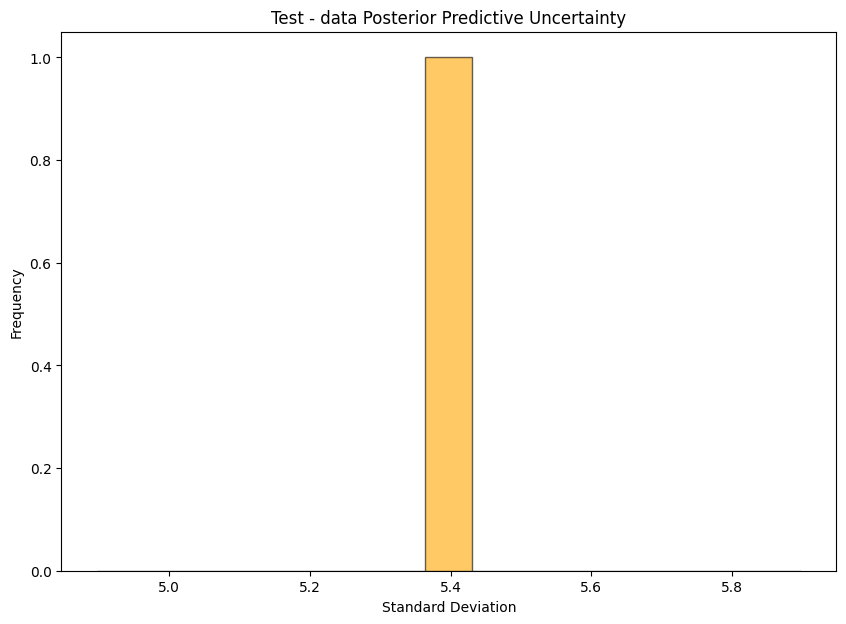

In [ ]:
predictions = np.array(predictions)
uncertainty_array = uncertain_regr_calc(predictions, label="Test - data")


In [ ]:
threshold = np.percentile(uncertainty_array, 95)

print(f"Selected threshold (95 percentile): {threshold:.2f}")

threshold = np.percentile(uncertainty_array, 90)

print(f"Selected threshold (90 percentile): {threshold:.2f}")

Selected threshold (95 percentile): 5.40
Selected threshold (90 percentile): 5.40


In [ ]:
# Load the Auto MPG dataset
mpg = sns.load_dataset('mpg')

mpg = mpg.dropna()

X = mpg[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin']]
y = mpg['mpg']

print("Features (X):")
print(X.head())

print("\nTarget (y):")
print(y.head())

# 1. Drop the 'name' column (not useful)
mpg = mpg.drop(columns=['name'])

# 2. Fill missing values in 'horsepower' with the column mean
mpg['horsepower'] = mpg['horsepower'].fillna(mpg['horsepower'].mean())

# 3. Convert 'origin' to a numerical variable (one-hot encoding)
mpg = pd.get_dummies(mpg, columns=['origin'], drop_first=True)

# 4. Select features and target
X = mpg.drop(columns=['mpg'])  # Features
y = mpg['mpg']  # Target (mpg)

# Display the prepared dataset
print(X.head())
print(y.head())

# Setting the interval for the training set
values = (mpg['cylinders'] >= 3) & (mpg['cylinders'] <= 6)


# Separate the data for 'cylinders = 8'
data_cyl_8 = mpg[mpg['cylinders'] == 8]

mpg.to_csv("preprocessed_mpg.csv", index=False)

Features (X):
   cylinders  displacement  horsepower  weight  acceleration  model_year  \
0          8         307.0       130.0    3504          12.0          70   
1          8         350.0       165.0    3693          11.5          70   
2          8         318.0       150.0    3436          11.0          70   
3          8         304.0       150.0    3433          12.0          70   
4          8         302.0       140.0    3449          10.5          70   

  origin  
0    usa  
1    usa  
2    usa  
3    usa  
4    usa  

Target (y):
0    18.0
1    15.0
2    18.0
3    16.0
4    17.0
Name: mpg, dtype: float64
   cylinders  displacement  horsepower  weight  acceleration  model_year  \
0          8         307.0       130.0    3504          12.0          70   
1          8         350.0       165.0    3693          11.5          70   
2          8         318.0       150.0    3436          11.0          70   
3          8         304.0       150.0    3433          12.0          

In [ ]:
# Read the dataset
mpg = pd.read_csv("preprocessed_mpg.csv")

# Drop columns that are not relevant for analysis
# mpg = mpg.drop(columns=['name'])

# Fill missing values
mpg['horsepower'] = mpg['horsepower'].fillna(mpg['horsepower'].mean())

# Apply one-hot encoding to the categorical column 'origin'
# mpg = pd.get_dummies(mpg, columns=['origin'], drop_first=True)

# Check the dataset
print(mpg.head())


    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0    3433          12.0   
4  17.0          8         302.0       140.0    3449          10.5   

   model_year  origin_japan  origin_usa  
0          70         False        True  
1          70         False        True  
2          70         False        True  
3          70         False        True  
4          70         False        True  


In [ ]:
from sklearn.model_selection import train_test_split

# 1. Split the data based on the training interval
train_interval = (mpg['cylinders'] >= 3) & (mpg['cylinders'] <= 6)
normal_traindata = mpg[train_interval]

# 2. Select all data for `cylinders = 8` (extrapolation)
data_cyl_7 = mpg[mpg['cylinders'] == 8]

# 3. Split the data for `cylinders = 8` into test and "extra train" (30% for testing)
test_data_extrapolated, extra_traindata = train_test_split(data_cyl_8, test_size=0.3, random_state=42)

# 4. Create the full training set (add 70% of `cylinders = 8` to the normal data)
train_data = pd.concat([normal_traindata, extra_traindata])

# 5. Create feature and target sets
X_extr_train = train_data.drop(columns=['mpg'])
y_extr_train = train_data['mpg']

X_extr_test = test_data_extrapolated.drop(columns=['mpg'])
y_extr_test = test_data_extrapolated['mpg']

# Check the dimensions
print(f"Number of examples in the training set: {len(X_extr_train)}")
print(f"Number of examples in the test set: {len(X_extr_test)}")


Number of examples in the training set: 320
Number of examples in the test set: 72


In [ ]:
# Verify the overlap between train and test
overlap = X_extr_test.merge(X_extr_train, how='inner')
print(f"Number of overlapped points between train and test: {len(overlap)}")



Number of overlapped points between train and test: 0


In [ ]:
# Apply one-hot encoding to categorical columns, ensuring all data are numeric
X_extr_train = pd.get_dummies(X_extr_train, drop_first=True)
X_extr_test = pd.get_dummies(X_extr_test, drop_first=True)

bayesian_nn_extr = create_bayesian_network(X_extr_train, y_extr_train)

with bayesian_nn_extr:
    # Adjust the model using the ADVI method
    approx_extrapolated = pm.fit(100000, method="advi", random_seed=42)
    trace_extrapolated = approx_extrapolated.sample(draws=1000, return_inferencedata=True)


Output()

In [ ]:
# Initialize variable to store predictions
predictions_extrapolated = None

with bayesian_nn_extr:
    # Set the test data for posterior prediction
    pm.set_data({
        "model_input": X_extr_test,
        "model_output": np.zeros(y_extr_test.shape)  # Placeholder
    }, coords={"samples": np.arange(X_extr_test.shape[0])})

    # Generate posterior predictions using the model
    ppc_extrapolated = pm.sample_posterior_predictive(trace_extrapolated, var_names=["output"])
    predictions_draws_extrapolated = np.squeeze(ppc_extrapolated.posterior_predictive["output"])

    # Compute the mean of predictions for each test point
    predictions_extrapolated = np.mean(predictions_draws_extrapolated, axis=0)


Output()

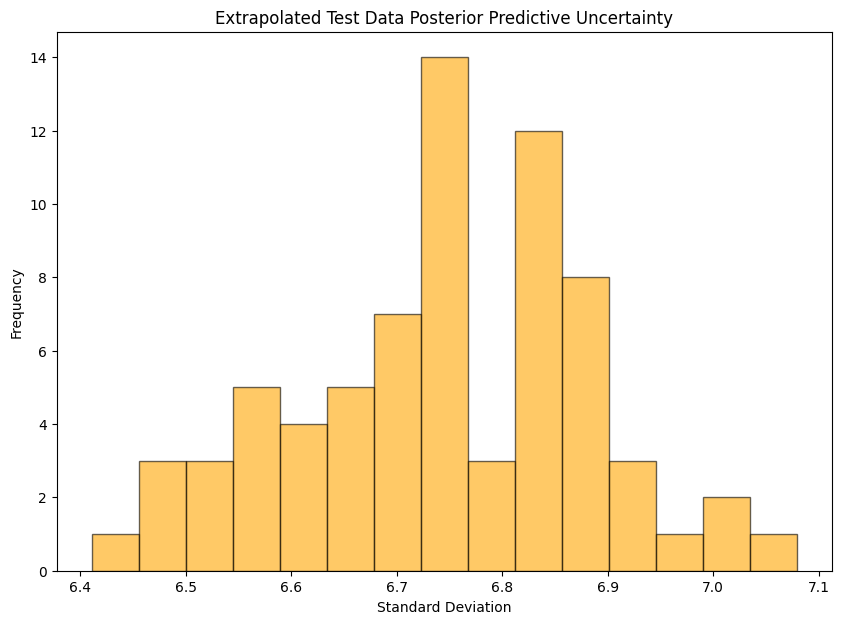

In [ ]:
# Calculate the uncertainty for the extrapolated points
uncertain_extr = uncertain_regr_calc(
    predictions_draws_extrapolated, label="Extrapolated Test Data"
)


In [ ]:
threshold_extrapolated = np.percentile(uncertain_extr, 77)
extrapolated_points = np.where(uncertain_extr > threshold_extrapolated)[0]

print(f"Calculated threshold: {threshold_extrapolated:.2f}")
print(f"Number of extrapolated points detected: {len(extrapolated_points)}")


Calculated threshold: 6.85
Number of extrapolated points detected: 17
